In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

from tqdm import tqdm
from scipy import stats
from scipy import signal
from functools import reduce
from random import choice, choices
from scipy.spatial.distance import euclidean
from pyts.classification import LearningShapelets

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC

from sklearn.metrics import matthews_corrcoef, classification_report, ConfusionMatrixDisplay,  confusion_matrix

In [3]:
ecg = np.loadtxt("ecg.csv", delimiter=",")
X, y = ecg[:,:-1], ecg[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

In [4]:
def to_windows(ts, wsize=10):
    N = len(ts)
    return np.concatenate([
        ts[i:i+wsize].reshape(1,-1) for i in range(0, N-wsize+1, wsize)
    ])

In [5]:
def get_window(ts, i, wsize):
    return to_windows(ts, wsize)[i]

In [6]:
get_window(X_train[0], 0, 10)

array([-0.83428968, -2.4412698 , -3.4136905 , -4.0632907 , -4.2733293 ,
       -3.9500028 , -3.2289364 , -2.1702874 , -1.6792556 , -1.3767368 ])

In [7]:
def get_window_from_array(X, i, wsize):
    return np.concatenate([
        get_window(x, i, wsize).reshape(1,-1) for x in X
    ])

In [7]:
get_window_from_array(X_train,0,10).shape

(3998, 10)

In [8]:
def get_distinct_sequences(X_pos, X_neg, wsize, _dist):
    assert(X_pos.shape[1]==X_neg.shape[1])
    
    N_windows = int(X_pos.shape[1]//wsize)
    selected_windows = np.zeros(shape=(len(X_pos), N_windows))
    
    xnegs = [get_window_from_array(X_neg, i, wsize) for i in range(N_windows)]
    
    #def _dist(w1, w2):
    #    return euclidean(w1,w2)
    
    c=0
    for x in tqdm(X_pos):
        dists = []
        for i, window in enumerate(to_windows(x, wsize)):
            xneg = xnegs[i]
            
            average_distance = np.apply_along_axis(
                _dist, 1, xneg, window
            ).mean()
            
            dists.append(average_distance)
            
        selected_windows[c]=dists
        c+=1
    
    #selected_windows, n_times_chosen = np.unique(selected_windows, return_counts=True)
    #max_selected_loc = np.argmax(n_times_chosen)
    return selected_windows#[max_selected_loc], n_times_chosen

In [9]:
def max_dist(w1, w2):
    return np.abs(w1-w2).max()

In [12]:
mean_distances = get_distinct_sequences(X_train[y_train==1], X_train[y_train==0], 10, max_dist)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2340/2340 [05:44<00:00,  6.79it/s]


This methodology of calculating every distance is infeasible for a large dataset, some heuristics would have to be created

In [13]:
mean_distances.mean(axis=0)

array([2.698901  , 1.02521731, 0.90828205, 1.04215599, 0.83050319,
       0.41264168, 0.4077437 , 0.41639356, 0.39358741, 0.6670786 ,
       1.26824824, 1.14834097, 1.60383658, 4.49368413])

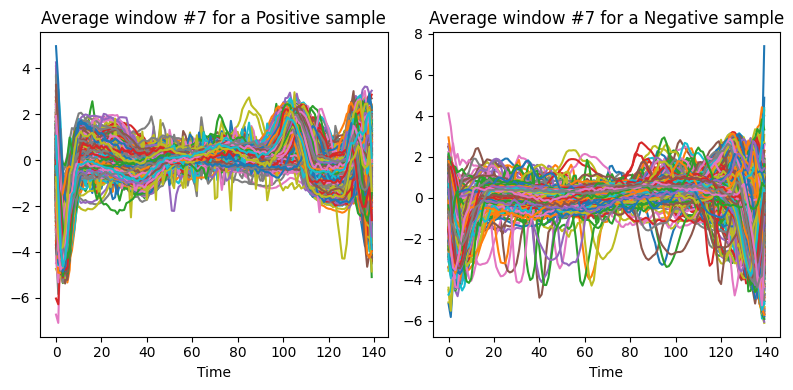

In [14]:
f, ax = plt.subplots(1,2, figsize=(8,4))
ax[0].plot(X_train[y_train==1].T)
ax[0].set_title("Average window #7 for a Positive sample")
ax[0].set_xlabel("Time")
ax[1].plot(X_train[y_train==0].T)
ax[1].set_title("Average window #7 for a Negative sample")
ax[1].set_xlabel("Time")

f.tight_layout()

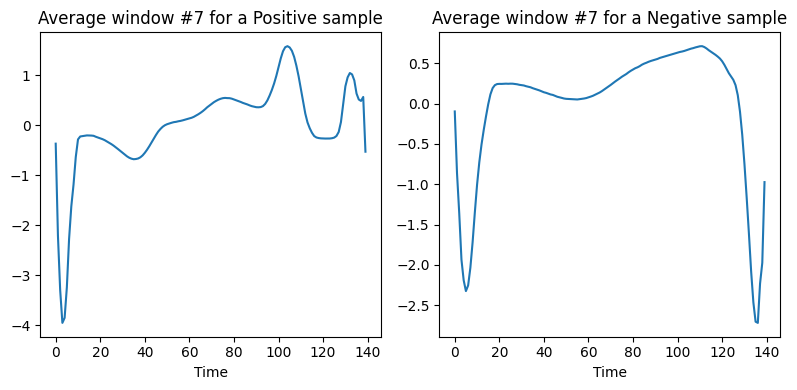

In [15]:
f, ax = plt.subplots(1,2, figsize=(8,4))
ax[0].plot(X_train[y_train==1].mean(axis=0))
ax[0].set_title("Average window #7 for a Positive sample")
ax[0].set_xlabel("Time")
ax[1].plot(X_train[y_train==0].mean(axis=0))
ax[1].set_title("Average window #7 for a Negative sample")
ax[1].set_xlabel("Time")

f.tight_layout()

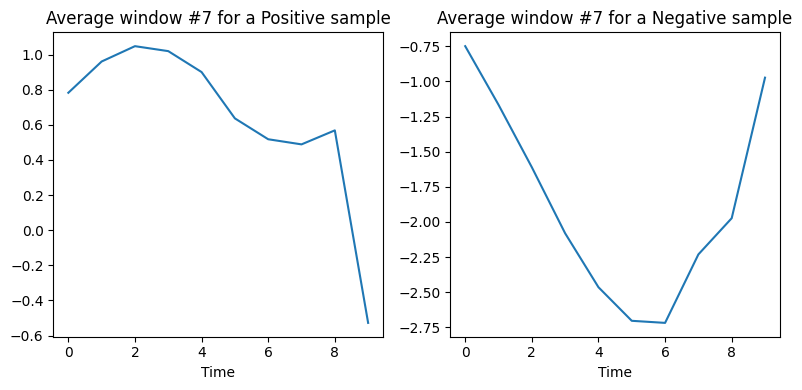

In [14]:
f, ax = plt.subplots(1,2, figsize=(8,4))
ax[0].plot(get_window_from_array(X_train[y_train==1], -1, 10).mean(axis=0))
ax[0].set_title("Average window #7 for a Positive sample")
ax[0].set_xlabel("Time")
ax[1].plot(get_window_from_array(X_train[y_train==0], -1, 10).mean(axis=0))
ax[1].set_title("Average window #7 for a Negative sample")
ax[1].set_xlabel("Time")

f.tight_layout()

We can see a clear difference in the window values of each of the classes, for window #7 of size 20

In [15]:
def get_shapelets(X_neg, X_pos, n_per_class, k):
    shapelets = [
        np.mean(choices(X_neg, k=k), axis=0) for _ in range(n_per_class)
    ] + [
        np.mean(choices(X_pos, k=k), axis=0) for _ in range(n_per_class)
    ]
    
    return np.array(shapelets)

In [24]:
shapes = get_shapelets(
    get_window_from_array(X_train[y_train==0], -1, 10), 
    get_window_from_array(X_train[y_train==1], -1, 10),
    5, 
    50)

In [17]:
def dist_to_shapes(w, shapes, dist_func):
    return [dist_func(w, s) for s in shapes]

In [20]:
def to_feat(X, dist_func):
    return np.apply_along_axis(
        lambda w: dist_to_shapes(w, shapes, dist_func),
        1, get_window_from_array(X, -1, 10)
    )

In [25]:
lr = LogisticRegression().fit(to_feat(X_train, max_dist), y_train)
lr.score(to_feat(X_train, max_dist), y_train)

0.9467233616808404

In [26]:
lr.score(to_feat(X_test, max_dist), y_test)

0.948

God results for this simple model